## Análisis Exploratorio (serie de tiempo de consumo de datos móviles)

El análisis de series de tiempo se refiere al proceso de analizar los datos disponibles para descubrir el patrón o la tendencia en los datos. Permite extraer y modelar las relaciones entre datos a lo largo del tiempo, sea extrapolando (hacia futuro) o interpolando (hacia el pasado) el comportamiento de datos no observados.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from statsmodels.tsa.seasonal import seasonal_decompose

OUTPUT_DIR = "./results/"

In [6]:
df = pd.read_csv("../data/synthetic_data/datos_a_completar.csv")

df["START_DATE"] = pd.to_datetime(df["START_DATE"])
df["END_DATE"] = pd.to_datetime(df["END_DATE"])

serie = pd.Series(df["ACTUAL_USAGE"].values, index=df["START_DATE"])
serie = serie.resample("1T").sum()

serie_df = serie.reset_index()
serie_df.columns = ["fecha", "consumo"]
serie_df.to_csv(OUTPUT_DIR + "serie_tiempo.csv", index=False)

C:\Users\Claudia\AppData\Local\Temp\ipykernel_18272\879768506.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  serie = serie.resample("1T").sum()


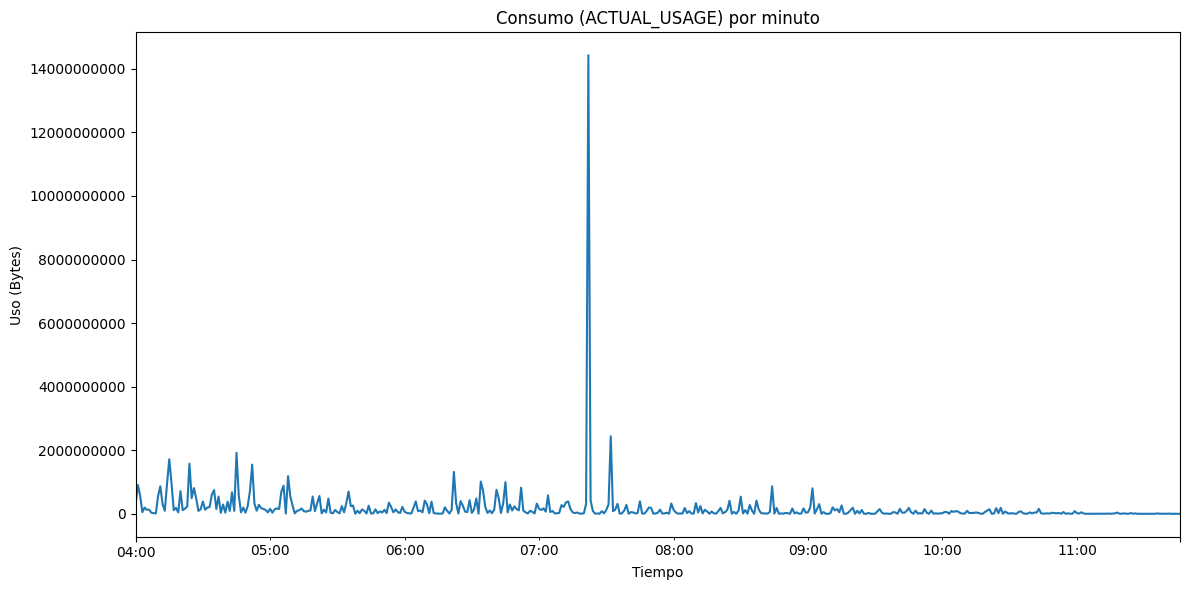

In [7]:
plt.figure(figsize=(12,6))
ax = serie.plot()

ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
plt.ticklabel_format(style="plain", axis="y")

plt.title("Consumo (ACTUAL_USAGE) por minuto")
plt.xlabel("Tiempo")
plt.ylabel("Uso (Bytes)")
plt.tight_layout()
plt.savefig(OUTPUT_DIR + "serie_tiempo.png", dpi=300)
plt.show()

### Componentes de las series de tiempo analizadas

#### Tendencia: 
Es el patrón subyacente en los datos a lo largo del tiempo. No es necesariamente lineal.

#### Estacionalidad: 
Cuando una serie está influenciada por factores estacionales de periodo fijo como el dia, mes, trimestre.

#### Aleatoriedad: 
parte inexplicable de los datos

<Figure size 1200x800 with 0 Axes>

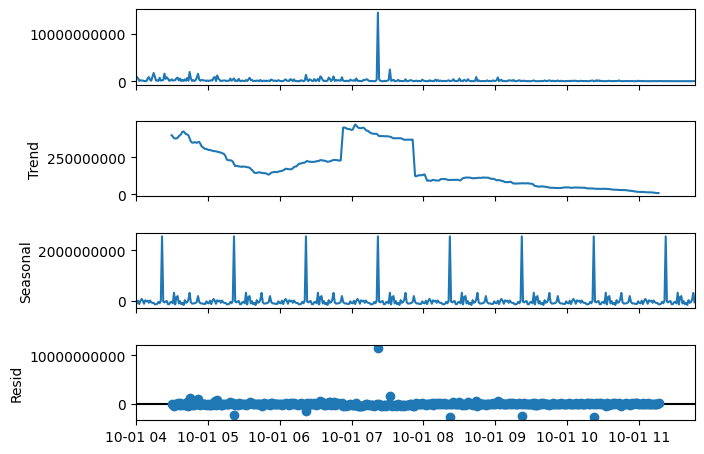

In [11]:
result = seasonal_decompose(serie, model="additive", period=60) # Se tienen los datos por minuto, capturar cada 60 (por hora)

plt.figure(figsize=(12,8))
axes = result.plot()
for ax in axes.axes: 
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False)) 
    ax.ticklabel_format(style="plain", axis="y")
    
plt.savefig(OUTPUT_DIR + "descomposition.png", dpi=300)
plt.show()

### 1. **Serie original**
- Se observa un **pico muy marcado** alrededor de *10-01 07* (más de 9GB), lo que indica un evento de consumo inusualmente alto.
- Este tipo de comportamiento puede deberse a una descarga masiva, actualización automática, o actividad de red anómala.

---

### 2. **Tendencia (Trend)**
- La tendencia muestra una **caída progresiva** en el consumo, pero con un **salto abrupto** en el mismo punto del pico.
- Esto sugiere que el evento no es completamente aleatorio: el modelo lo interpreta como parte de la evolución estructural del consumo.

---

### 3. **Estacionalidad (Seasonal)**
- Aquí se ven **picos regulares cada 60 minutos** (alrededor de los 2GB), lo que indica que hay **patrones horarios repetitivos**.
- Puede que cada hora haya un pequeño repunte por sincronizaciones, uso de apps, o hábitos de los usuarios.
- Este componente es clave si quieres modelar el comportamiento **intra-horario**.

---

### 4. **Residuo (Resid)**
- El residuo muestra **ruido y varios outliers**, especialmente uno grande en el mismo punto del pico.
- Esto indica que, aunque parte del evento fue absorbido por la tendencia y la estacionalidad, **aún queda una porción inexplicable**, lo que lo convierte en un buen candidato para **detección de anomalías**.